

**ECG Heartbeat Categorization Dataset**


# **About Dataset**

This dataset is composed of two collections of heartbeat signals derived from two famous datasets in heartbeat classification, the MIT-BIH Arrhythmia Dataset and The PTB Diagnostic ECG Database. The number of samples in both collections is large enough for training a deep neural network.

This dataset has been used in exploring heartbeat classification using deep neural network architectures, and observing some of the capabilities of transfer learning on it. The signals correspond to electrocardiogram (ECG) shapes of heartbeats for the normal case and the cases affected by different arrhythmias and myocardial infarction. These signals are preprocessed and segmented, with each segment corresponding to a heartbeat.

**Content**

**Arrhythmia Dataset**

Number of Samples: 109446

Number of Categories: 5

Sampling Frequency: 125Hz

Data Source:

Physionet's MIT-BIH Arrhythmia Dataset
Classes: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

**The PTB Diagnostic ECG Database**

Number of Samples: 14552

Number of Categories: 2

Sampling Frequency: 125Hz

Data Source:

Physionet's PTB Diagnostic Database

Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.

**Data Files**

This dataset consists of a series of CSV files. Each of these CSV files contain a matrix, with each row representing an example in that portion of the dataset. The final element of each row denotes the class to which that example belongs.

**Acknowledgements**

Mohammad Kachuee, Shayan Fazeli, and Majid Sarrafzadeh. "ECG Heartbeat Classification: A Deep Transferable Representation." arXiv preprint arXiv:1805.00794 (2018).

**Inspiration**

Can you identify myocardial infarction?

## **Project Statement**

In this notebook, the goal is to predict different types of arrhythmia in electrocardiogram (ECG) data. Two different datasets are available, but initially, we will focus on the MIT-BIH dataset. The MIT-BIH Arrhythmia Database contains 48 half-hour excerpts of two-channel ambulatory ECG recordings from 47 subjects, obtained by the BIH Arrhythmia Laboratory between 1975 and 1979.

The dataset consists of 23 recordings chosen at random from a set of 4000 24-hour ambulatory ECG recordings collected from a mixed population of inpatients (about 60%) and outpatients (about 40%) at Boston's Beth Israel Hospital. The remaining 25 recordings were selected to include less common but clinically significant arrhythmias that would not be well-represented in a small random sample.

The dataset contains 109,446 samples with five categories of arrhythmia:

 'N' for normal beats,

 'S' for supraventricular ectopic beats,

 'V' for ventricular ectopic beats,

 'F' for fusion beats, and

 'Q' for unknown beats.



**ECG** stands for electrocardiogram, which is a diagnostic tool used to measure the electrical activity of the heart. It is a non-invasive test that involves attaching small electrodes to the skin on the chest, arms, and legs. These electrodes detect the electrical signals generated by the heart each time it beats, and these signals are recorded and displayed as a graph.

The ECG graph shows the different electrical waves that correspond to each phase of the heartbeat, including the P wave, QRS complex, and T wave. These waves are used to identify abnormalities in the heart's rhythm, which can indicate various heart conditions such as arrhythmias, heart attacks, and heart failure.

An ECG is a routine test that can be performed in a doctor's office, clinic, or hospital. It is a quick and painless procedure that usually takes only a few minutes to complete. ECGs are commonly used to diagnose and monitor heart conditions, as well as to check the effectiveness of treatments such as medication or surgery.

In [ ]:
import os
import pathlib
import random
import time

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from glob import glob
from tqdm import tqdm_notebook, tnrange
from skimage.color import rgb2gray
from skimage.morphology import label
from skimage.transform import resize
from skimage.io import imread, imshow, concatenate_images
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix, accuracy_score, auc, f1_score, precision_score, recall_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Conv1D, MaxPool1D, Flatten, Dropout, InputLayer, LSTM, GRU, BatchNormalization, Bidirectional, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical


# **Upload the dataset**

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"anouri","key":"3464baaaa0126fcf846c455c3fbbdcc9"}'}

In [ ]:
# mounts Google Drive to Google Colab, so that we can access files stored on Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q kaggle

In [ ]:
#copies the Kaggle API key file ('kaggle.json') from Google Drive to the '/content' #directory in Google Colab.
#This file is used to authenticate Kaggle account when using the Kaggle API to download datasets.
!cp '/content/drive/MyDrive/Kaggle/kaggle.json' '/content'

In [ ]:
import zipfile
import os

#sets the 'KAGGLE_CONFIG_DIR' environment variable to '/content',
#which tells the Kaggle API to look for the 'kaggle.json' file in the '/content' directory.
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

In [ ]:
# use the Kaggle API to download the Kaggle 3M MRI dataset to the '/content' directory in #Google Colab.
!kaggle datasets download -d shayanfazeli/heartbeat

 87% 86.0M/98.8M [00:00<00:00, 139MB/s]
100% 98.8M/98.8M [00:00<00:00, 112MB/s]


In [ ]:
#extracts the contents of the lgg-mri-segmentation.zip file to
#the /content/lgg-mri-segmentation directory in Google Colab.
!unzip -qn /content/heartbeat.zip -d /content/heartbeat


# **EDA**

In [ ]:
# Load MIT-BIH training and test datasets
mit_train_df = pd.read_csv('/content/heartbeat/mitbih_train.csv', header=None)
mit_test_df = pd.read_csv('/content/heartbeat/mitbih_test.csv', header=None)

# Load PTB diagnostic ECG datasets
ptb_abnormal_df = pd.read_csv('/content/heartbeat/ptbdb_abnormal.csv', header=None)
ptb_normal_df = pd.read_csv('/content/heartbeat/ptbdb_normal.csv', header=None)


In [ ]:
mit_train_df.head(1)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.04902,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
mit_train_df.isnull().sum()

0      0
1      0
2      0
3      0
4      0
      ..
183    0
184    0
185    0
186    0
187    0
Length: 188, dtype: int64

In [ ]:
mit_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


<Axes: xlabel='187', ylabel='count'>

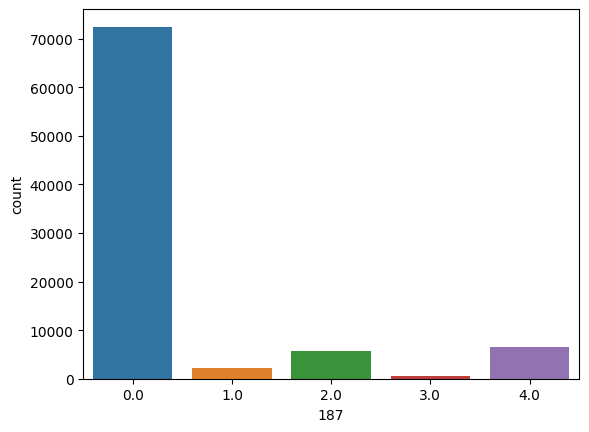

In [ ]:
sns.countplot(x=187, data = mit_train_df)

In [ ]:
datasets = [mit_train_df, mit_test_df, ptb_abnormal_df, ptb_normal_df]
for df in datasets:
    df.rename(columns={187: "Class"}, inplace=True)


In [ ]:
datasets = [("MIT-BIH Train", mit_train_df),
            ("MIT-BIH Test", mit_test_df),
            ("PTB Abnormal", ptb_abnormal_df),
            ("PTB Normal", ptb_normal_df)]

for dataset_name, dataset in datasets:
    print(f"{dataset_name} Classes:")
    print(dataset["Class"].value_counts())


MIT-BIH Train Classes:
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: Class, dtype: int64
MIT-BIH Test Classes:
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: Class, dtype: int64
PTB Abnormal Classes:
1.0    10506
Name: Class, dtype: int64
PTB Normal Classes:
0.0    4046
Name: Class, dtype: int64


In [ ]:
# Define dictionaries to describe the type of heartbeat for both datasets
mit_outcome_dict = {0: "Normal Beat",
                    1: "Supraventricular Premature Beat",
                    2: "Premature Ventricular Contraction",
                    3: "Fusion of Ventricular and Normal Beat",
                    4: "Unclassifiable Beat"}

ptb_outcome_dict = {0: "Normal",
                    1: "Abnormal"}


# **Visualization**

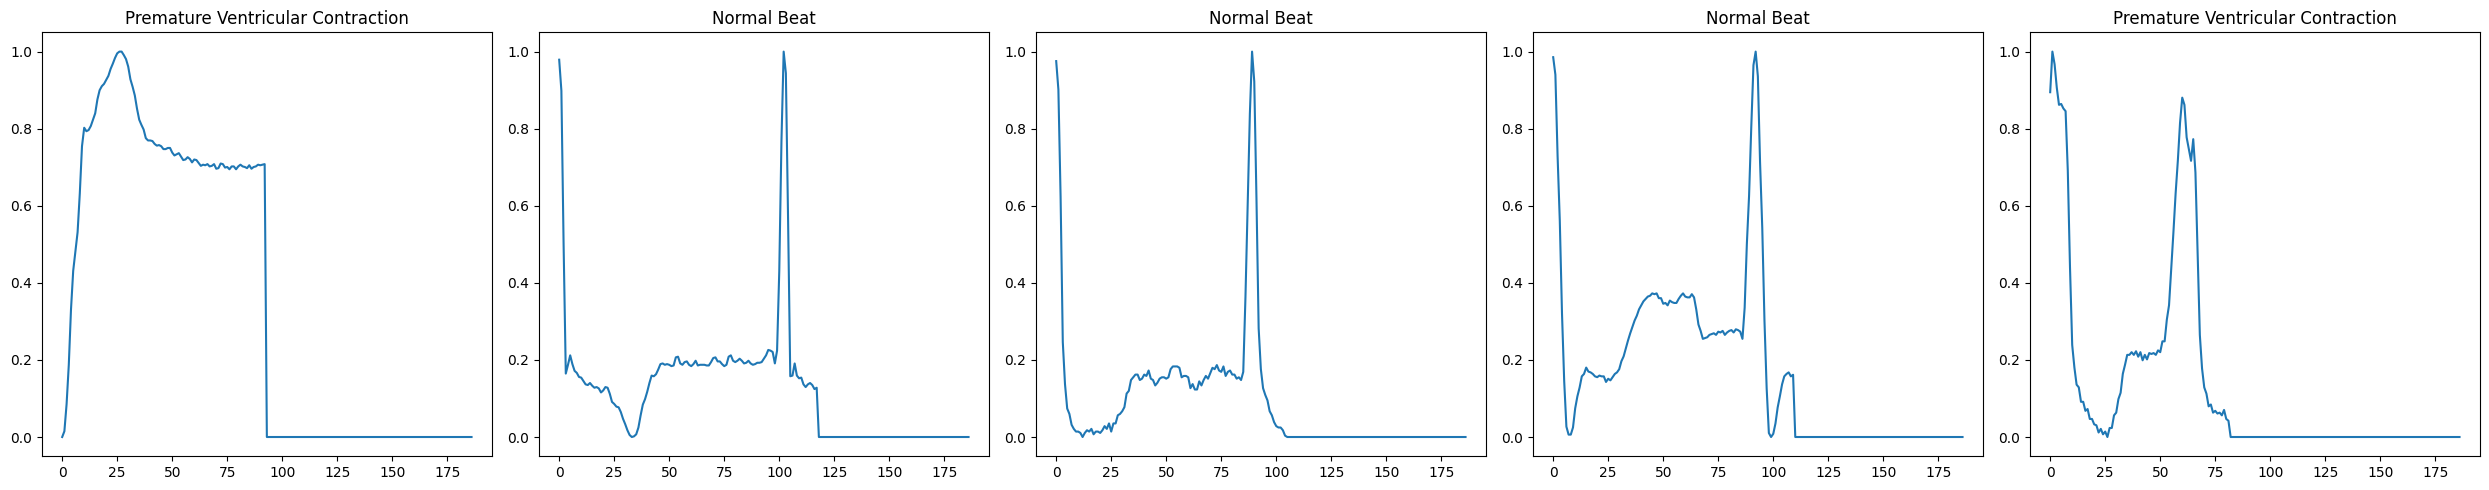

In [ ]:
np.random.seed(None) # Optional

# Select 5 random samples from the MIT training dataset
rnd_idx = np.random.randint(0, mit_train_df.shape[0], size=5)
rnd_samples = mit_train_df.iloc[rnd_idx, :-1]
rnd_labels = mit_train_df.iloc[rnd_idx, -1]

# Plot the selected samples with their classification
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25, 5))

for i, ax in enumerate(axes.flatten()):
    ax.plot(rnd_samples.iloc[i, :])
    ax.set_title(mit_outcome_dict[rnd_labels.iloc[i]])

plt.tight_layout()
plt.show()


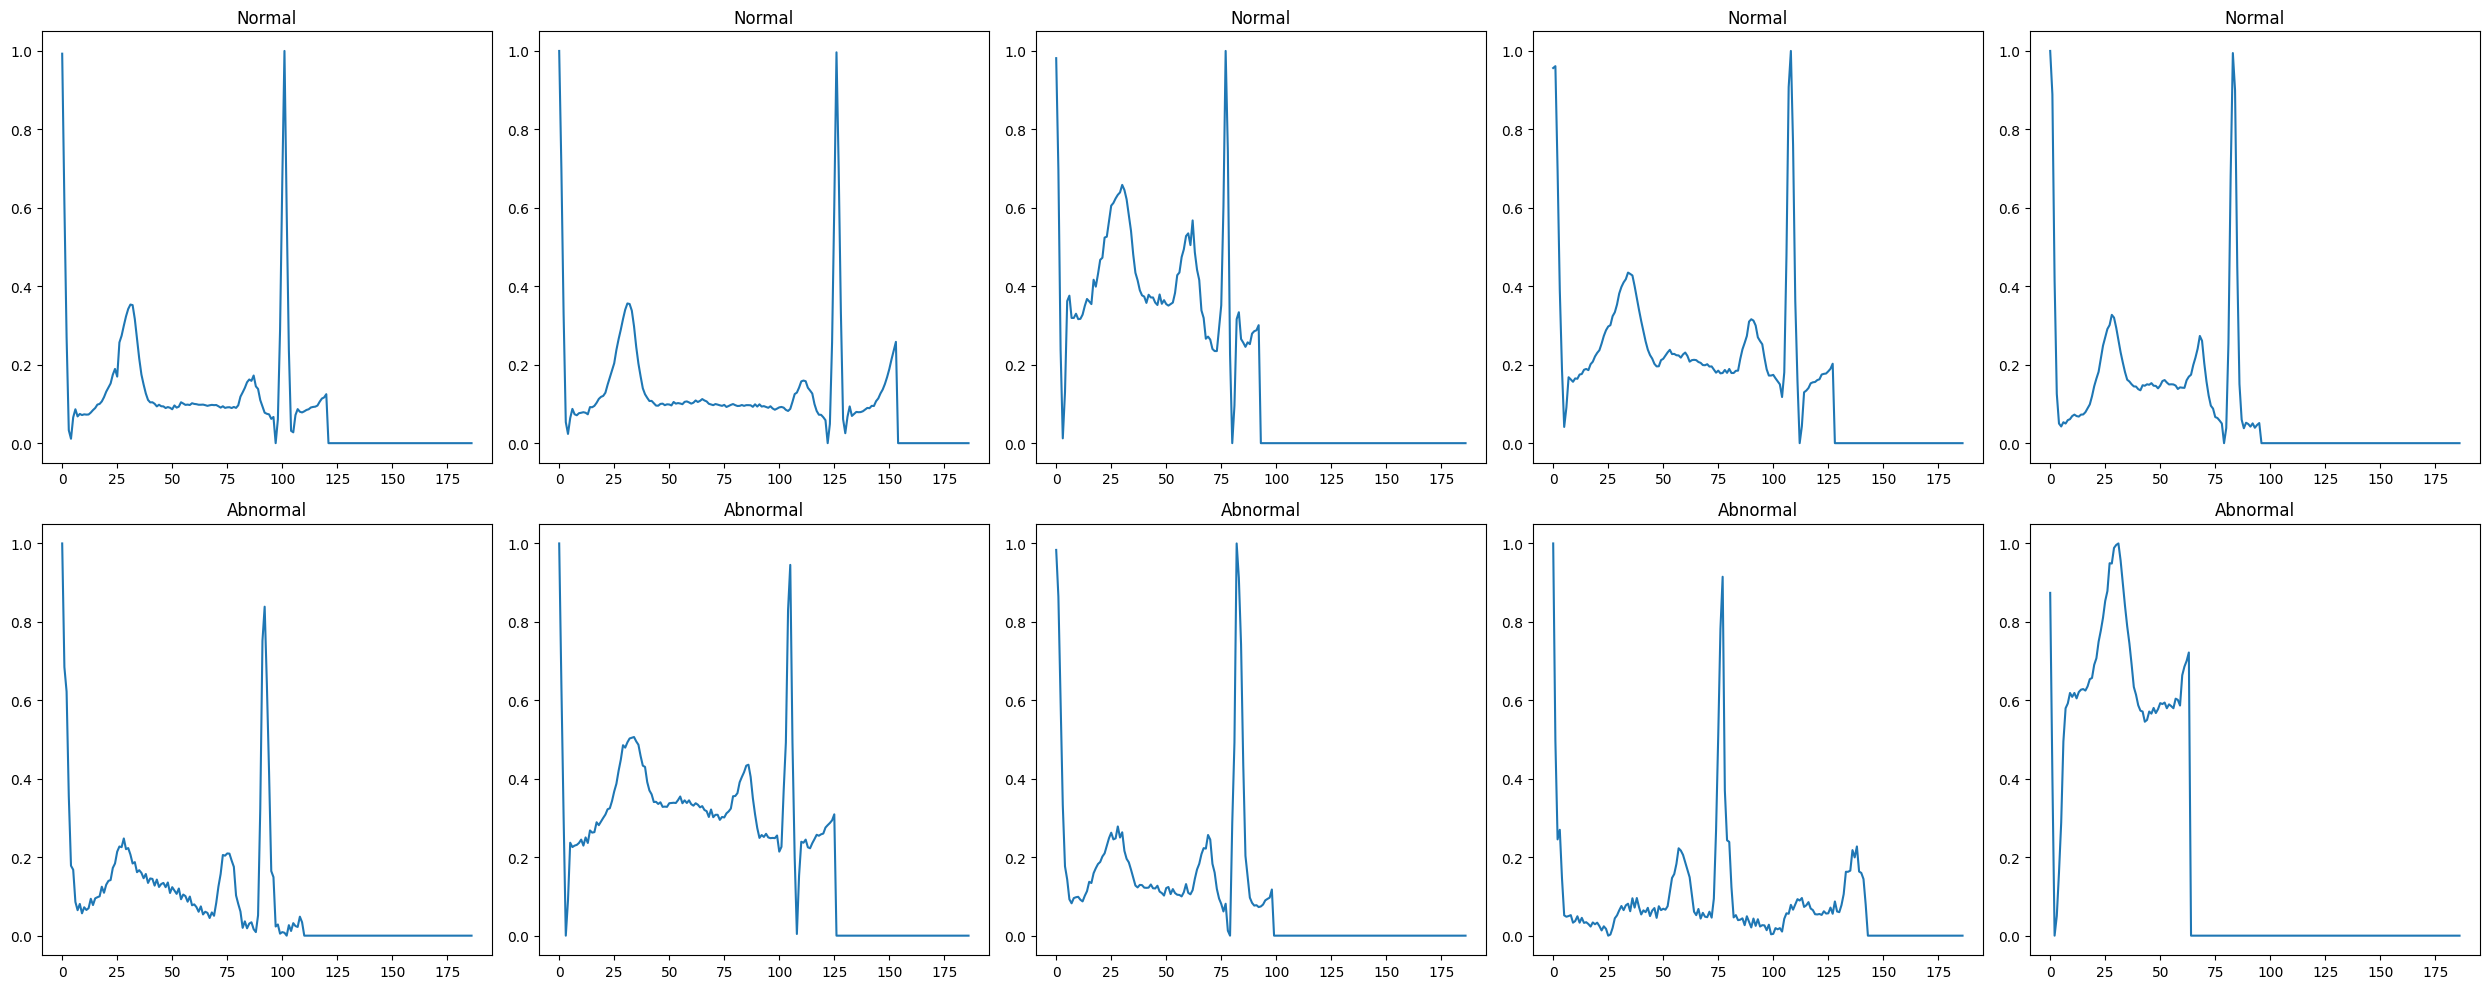

In [ ]:
# Select 5 random samples from the PTB normal dataset
rnd_idx_normal = np.random.randint(0, ptb_normal_df.shape[0], size=5)
rnd_samples_normal = ptb_normal_df.iloc[rnd_idx_normal, :-1]
rnd_labels_normal = ptb_normal_df.iloc[rnd_idx_normal, -1]

# Select 5 random samples from the PTB abnormal dataset
rnd_idx_abnormal = np.random.randint(0, ptb_abnormal_df.shape[0], size=5)
rnd_samples_abnormal = ptb_abnormal_df.iloc[rnd_idx_abnormal, :-1]
rnd_labels_abnormal = ptb_abnormal_df.iloc[rnd_idx_abnormal, -1]

# Plot the selected samples with their classification
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10))

for i, ax in enumerate(axes.flatten()):
    if i < 5:
        ax.plot(rnd_samples_normal.iloc[i, :])
        ax.set_title(ptb_outcome_dict[rnd_labels_normal.iloc[i]])
    else:
        ax.plot(rnd_samples_abnormal.iloc[i - 5, :])
        ax.set_title(ptb_outcome_dict[rnd_labels_abnormal.iloc[i - 5]])

plt.tight_layout()
plt.show()


# **Next**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Concatenate the PTB normal and abnormal datasets into a single dataframe
ptb_full_df = pd.concat([ptb_normal_df, ptb_abnormal_df], axis=0, ignore_index=True)

# Split the data into training, validation, and test sets
train_ptb_df, test_ptb_df, out_train_ptb_df, out_test_ptb_df = train_test_split(ptb_full_df.iloc[:, :-1], ptb_full_df.iloc[:, -1], test_size=0.2, random_state=42)
train_ptb_df, valid_ptb_df, out_train_ptb_df, out_valid_ptb_df = train_test_split(train_ptb_df, out_train_ptb_df, test_size=0.25, random_state=42)


# **class weight**

In [ ]:
# Calculate the number of samples for each class
counts = np.bincount(ptb_full_df.loc[:, 'Class'])
total_count = counts.sum()

# Calculate the weights for each class
class_weights = {}
for i, count in enumerate(counts):
    weight = (1 / count) * (total_count / 2)
    class_weights[i] = weight


In [ ]:
print(f"Training dataset size: {train_ptb_df.shape}")
print(f"Validation dataset size: {valid_ptb_df.shape}")
print(f"Test dataset size: {test_ptb_df.shape}")


Training dataset size: (8730, 187)
Validation dataset size: (2911, 187)
Test dataset size: (2911, 187)


In [ ]:
# Normalizing the training, validation & test data
train_ptb_norm = normalize(train_ptb_df, axis=0, norm='max')
valid_ptb_norm = normalize(valid_ptb_df, axis=0, norm='max')
test_ptb_norm = normalize(test_ptb_df, axis=0, norm='max')


In [ ]:
# Reshaping the dataframe into a 3-D Numpy array (batch, Time Period, Value)
x_train_ptb = train_ptb_norm.reshape(len(train_ptb_norm), train_ptb_norm.shape[1], 1)
x_valid_ptb = valid_ptb_norm.reshape(len(valid_ptb_norm), valid_ptb_norm.shape[1], 1)
x_test_ptb = test_ptb_norm.reshape(len(test_ptb_norm), test_ptb_norm.shape[1], 1)

# Converting the output into a categorical array
y_train_ptb = to_categorical(out_train_ptb_df)
y_valid_ptb = to_categorical(out_valid_ptb_df)
y_test_ptb = to_categorical(out_test_ptb_df)

In [ ]:
training_data_size = x_train_ptb.shape[0]
training_label_size = y_train_ptb.shape[0]
validation_data_size = x_valid_ptb.shape[0]
validation_label_size = y_valid_ptb.shape[0]
test_data_size = x_test_ptb.shape[0]
test_label_size = y_test_ptb.shape[0]

print(f"Training dataset size: {training_data_size} -- Label size: {training_label_size}")
print(f"Validation dataset size: {validation_data_size} -- Label size: {validation_label_size}")
print(f"Test dataset size: {test_data_size} -- Label size: {test_label_size}")


Training dataset size: 8730 -- Label size: 8730
Validation dataset size: 2911 -- Label size: 2911
Test dataset size: 2911 -- Label size: 2911


# **CNN for PTB**

In [ ]:
tf.keras.backend.clear_session()

#Convolutional 1D Networks
def build_model(input_shape=(x_train_ptb.shape[1], 1)):
    model = keras.models.Sequential()

    model.add(Conv1D(32, 7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5, padding='same'))

    model.add(Conv1D(64, 7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5, padding='same'))

    model.add(Conv1D(128, 7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5, padding='same'))

    model.add(Conv1D(256, 7, padding='same'))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5, padding='same'))

    model.add(Conv1D(512, 7, padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(MaxPool1D(5, padding='same'))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
checkpoint_cb = ModelCheckpoint("my_model.h5", save_best_only=True)
earlystop_cb = EarlyStopping(patience=6, restore_best_weights=True)
model = build_model(input_shape=(x_train_ptb.shape[1], x_train_ptb.shape[2]))


In [ ]:
history = model.fit(x_train_ptb, y_train_ptb, epochs=51, batch_size=32,
                    class_weight=class_weights, validation_data=(x_valid_ptb, y_valid_ptb),
                    callbacks=[checkpoint_cb, earlystop_cb])


Epoch 1/51
273/273 [==============================] - 35s 31ms/step - loss: 0.3855 - accuracy: 0.8233 - val_loss: 1.0873 - val_accuracy: 0.7262
Epoch 2/51
273/273 [==============================] - 4s 13ms/step - loss: 0.2094 - accuracy: 0.9155 - val_loss: 0.3290 - val_accuracy: 0.8310
Epoch 3/51
273/273 [==============================] - 5s 18ms/step - loss: 0.1423 - accuracy: 0.9462 - val_loss: 0.4832 - val_accuracy: 0.8286
Epoch 4/51
273/273 [==============================] - 4s 13ms/step - loss: 0.1232 - accuracy: 0.9551 - val_loss: 0.1950 - val_accuracy: 0.9076
Epoch 5/51
273/273 [==============================] - 4s 13ms/step - loss: 0.1302 - accuracy: 0.9546 - val_loss: 0.1190 - val_accuracy: 0.9557
Epoch 6/51
273/273 [==============================] - 4s 15ms/step - loss: 0.0863 - accuracy: 0.9688 - val_loss: 0.3118 - val_accuracy: 0.9220
Epoch 7/51
273/273 [==============================] - 6s 22ms/step - loss: 0.0688 - accuracy: 0.9753 - val_loss: 0.1078 - val_accuracy: 0.975

In [ ]:
model.load_weights("my_model.h5")
model.evaluate(x_test_ptb, y_test_ptb)


91/91 [==============================] - 0s 4ms/step - loss: 0.0407 - accuracy: 0.9897


[0.04067068174481392, 0.9896942377090454]

In [ ]:
# Calculating the predictions based on the highest probability class
my_model_pred_proba_ptb = model.predict(x_test_ptb)
my_model_pred_ptb = np.argmax(my_model_pred_proba_ptb, axis=1)


91/91 [==============================] - 1s 3ms/step


In [ ]:
print(classification_report(out_test_ptb_df, my_model_pred_ptb > 0.5, target_names=[ptb_outcome_dict[i] for i in ptb_outcome_dict]))


              precision    recall  f1-score   support

      Normal       0.97      0.99      0.98       834
    Abnormal       1.00      0.99      0.99      2077

    accuracy                           0.99      2911
   macro avg       0.99      0.99      0.99      2911
weighted avg       0.99      0.99      0.99      2911



<ipython-input-31-d0797faa2725>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.0, 0.0, 1.0, 1)). The keyword argument will take precedence.
  plt.plot(epochs, metric, 'b', color='#ff0066')


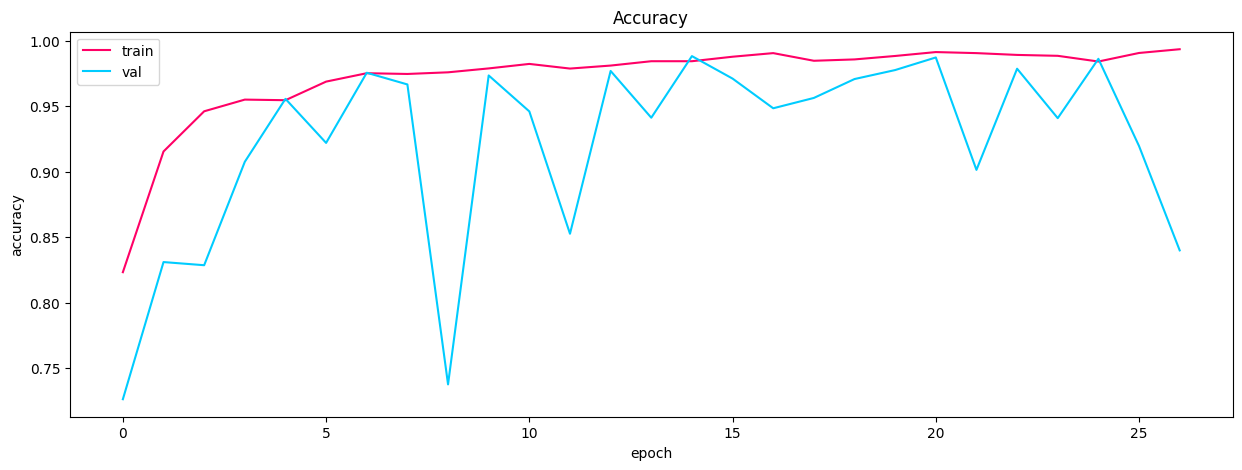

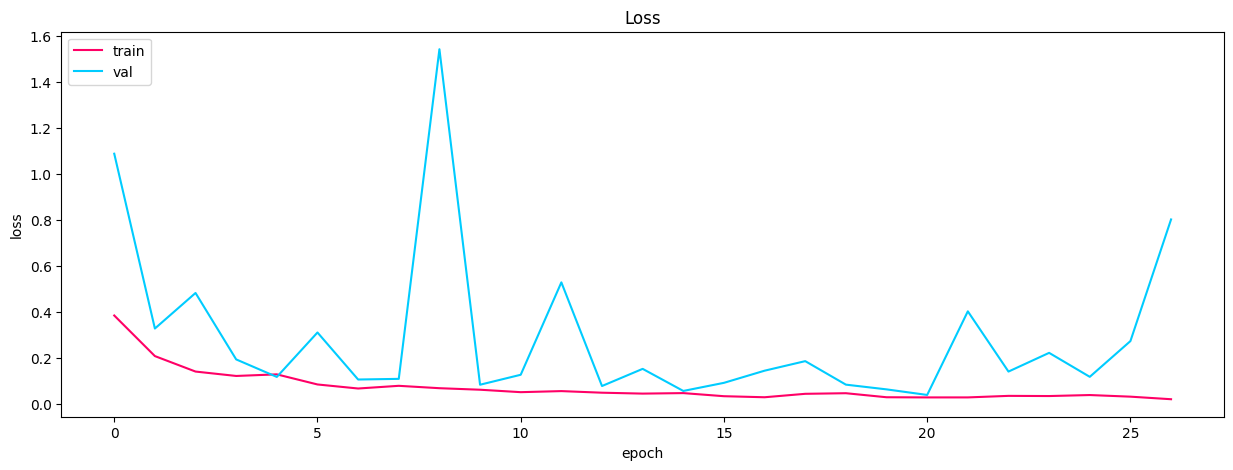

In [ ]:
def plot_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]
    epochs = range(len(metric))

    plt.figure(figsize=(15, 5))
    plt.plot(epochs, metric, 'b', color='#ff0066')
    plt.plot(epochs, val_metric, color='#00ccff')
    plt.legend(['train', 'val'], loc='upper left')
    plt.ylabel(metric_name)
    plt.xlabel('epoch')
    plt.title(metric_name.capitalize())


plot_metric(history, 'accuracy')
plot_metric(history, 'loss')


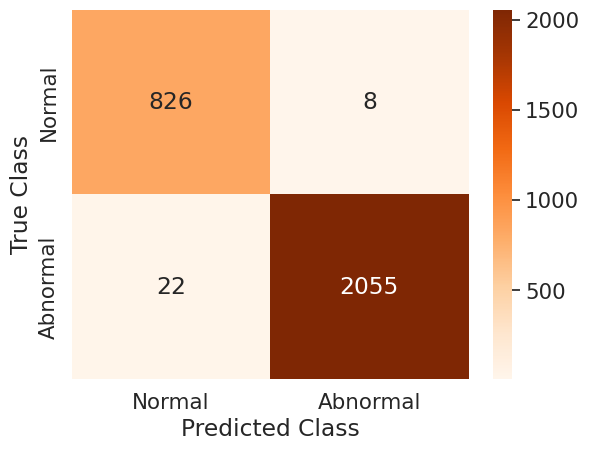

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true=out_test_ptb_df, y_pred=my_model_pred_ptb, labels=[0, 1])

sns.set(font_scale=1.4) # set font scale
sns.heatmap(cm, annot=True, fmt='d', cmap="Oranges", xticklabels=ptb_outcome_dict.values(),
            yticklabels=ptb_outcome_dict.values())
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
